In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retina-blood-vessel/Data/test/mask/11.png
/kaggle/input/retina-blood-vessel/Data/test/mask/4.png
/kaggle/input/retina-blood-vessel/Data/test/mask/9.png
/kaggle/input/retina-blood-vessel/Data/test/mask/14.png
/kaggle/input/retina-blood-vessel/Data/test/mask/1.png
/kaggle/input/retina-blood-vessel/Data/test/mask/2.png
/kaggle/input/retina-blood-vessel/Data/test/mask/10.png
/kaggle/input/retina-blood-vessel/Data/test/mask/18.png
/kaggle/input/retina-blood-vessel/Data/test/mask/12.png
/kaggle/input/retina-blood-vessel/Data/test/mask/7.png
/kaggle/input/retina-blood-vessel/Data/test/mask/17.png
/kaggle/input/retina-blood-vessel/Data/test/mask/5.png
/kaggle/input/retina-blood-vessel/Data/test/mask/3.png
/kaggle/input/retina-blood-vessel/Data/test/mask/16.png
/kaggle/input/retina-blood-vessel/Data/test/mask/8.png
/kaggle/input/retina-blood-vessel/Data/test/mask/6.png
/kaggle/input/retina-blood-vessel/Data/test/mask/15.png
/kaggle/input/retina-blood-vessel/Data/test/mask/13.png
/

In [2]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score



In [3]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples



In [4]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [5]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [6]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [7]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [8]:
con=conv_block(3,64)
a=torch.rand([1,3,512,512])
x=con(a)
print(x.shape)

torch.Size([1, 64, 512, 512])


In [9]:
double = build_unet()  # Example: increase channels from 3 to 64
a = torch.randn([1, 3, 512, 512])
x = double(a)
print(x.shape)  # Should be [1, 64, 512, 512]


torch.Size([1, 1, 512, 512])


In [10]:
xcv=nn.Conv2d(3,64,kernel_size=3,padding=1)
print(xcv(a).shape)

torch.Size([1, 64, 512, 512])


In [11]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [13]:

def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [14]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [17]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [18]:
seeding(42)


create_dir("files")


train_x = sorted(glob("/kaggle/input/retina-blood-vessel/Data/train/image/*"))
train_y = sorted(glob("/kaggle/input/retina-blood-vessel/Data/train/mask/*"))

valid_x = sorted(glob("/kaggle/input/retina-blood-vessel/Data/test/image/*"))
valid_y = sorted(glob("/kaggle/input/retina-blood-vessel/Data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



In [19]:
H = 512
W = 512
size = (H, W)
batch_size = 2
lr = 5e-3
checkpoint_path = "files/checkpoint.pth"

In [20]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [21]:
# Set cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model = build_unet()
model = model.to(device)
for name, layer in model.named_modules():
    print(name, "→", layer)


# Set Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

 → build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
import matplotlib.pyplot as plt

# Step 1: Initialize lists
train_losses = []
val_losses = []
train_dcs = []
val_dcs = []

# epochs_list = list(range(1, num_epochs + 1))


In [23]:
print(f"len(train_losses) = {len(train_losses)}")
print(f"len(val_losses) = {len(val_losses)}")
# print(f"len(epochs_list) = {len(epochs_list)}")


len(train_losses) = 0
len(val_losses) = 0


In [24]:
best_valid_loss = float("inf")
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    


    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    # train_dcs.append(train_dice)
    # val_dcs.append(val_dice)

    # Saving the model
    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\tVal. Loss: {valid_loss:.3f}\n'
    print(data_str)

Valid loss improved from inf to 1.3599. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.959
	Val. Loss: 1.360

Valid loss improved from 1.3599 to 1.3477. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.561
	Val. Loss: 1.348

Valid loss improved from 1.3477 to 1.0185. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.525
	Val. Loss: 1.018

Valid loss improved from 1.0185 to 0.5599. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.515
	Val. Loss: 0.560

Valid loss improved from 0.5599 to 0.5200. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.484
	Val. Loss: 0.520

Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.490
	Val. Loss: 0.559

Valid loss improved from 0.5200 to 0.4807. Saving checkpoint: files/checkpoint.pth
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.451
	Val. Loss: 0.481

Valid loss improved fr

In [25]:
print(f"len(train_losses) = {len(train_losses)}")
print(f"len(val_losses) = {len(val_losses)}")
# print(f"len(epochs_list) = {len(epochs_list)}")


len(train_losses) = 50
len(val_losses) = 50


In [26]:
print("Train loss:", train_loss)

Train loss: 0.3458154030144215


In [27]:
def calculate_metrics(y_true, y_pred):
    
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [28]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [29]:
#  Seeding
seeding(42)


create_dir("results")


test_x = sorted(glob("/kaggle/input/retina-blood-vessel/Data/test/image/*"))
test_y = sorted(glob("/kaggle/input/retina-blood-vessel/Data/test/mask/*"))

In [30]:
checkpoint_path = "files/checkpoint.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [31]:
metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    # Extract the name
    name = x.split("/")[-1].split(".")[0]

    # Reading image
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    # Reading mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y / 255.0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
        # Prediction and Calculating FPS
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)


        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    # Saving masks
    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128

    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )
    cv2.imwrite(f"results/{name}.png", cat_images)

100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


In [32]:
jaccard = metrics_score[0] / len(test_x)
f1 = metrics_score[1] / len(test_x)
recall = metrics_score[2] / len(test_x)
precision = metrics_score[3] / len(test_x)
acc = metrics_score[4] / len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")
fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

Jaccard: 0.6728 - F1: 0.8038 - Recall: 0.7799 - Precision: 0.8374 - Acc: 0.9671
FPS:  216.573542662257


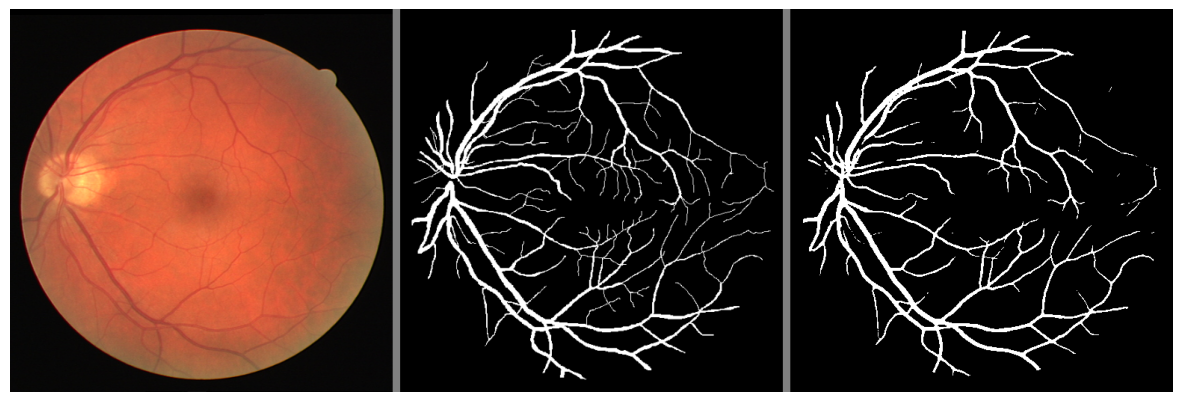

In [33]:
import matplotlib.pyplot as plt

img = plt.imread('/kaggle/working/results/11.png')
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.axis('off')

plt.show()

In [34]:
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00


In [35]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models

def preprocess_image(img_path):
    img=cv2.imread(img_path,cv2.IMREAD_COLOR)
    img=cv2.imresize(img,(224,224))
    img=transforms.ToTensor()(img)
    img=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])(img)
    img=img.unsqueeze(0)
    return img
def get_class_label(preds):
    _,class_index=torch.max(preds,1)
    return class_index.item()
def get_conv_layer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Layer '{conv_layer_name}' not found in the model.")
    

In [36]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()  # Set model to evaluation mode
        self.target_layer = target_layer  # Layer to visualize
        self.activations = None  # Store feature maps (forward pass)
        self.gradients = None    # Store gradients (backward pass)
        self._register_hooks()   # Register forward and backward hooks

    def _register_hooks(self):
        # Save activations from forward pass
        def forward_hook(module, input, output):
            self.activations = output

        # Save gradients from backward pass
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Attach hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor):
        input_tensor.requires_grad = True  # Enable gradient tracking
        output = self.model(input_tensor)  # Forward pass
        pred = torch.sigmoid(output)       # Apply sigmoid activation
        score = pred.mean()                # Use mean output for backward pass
        self.model.zero_grad()             # Zero previous gradients
        score.backward(retain_graph=True)  # Backward pass to compute gradients

        # Compute channel-wise importance
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Get activations for the input image
        activations = self.activations[0]
        for i in range(len(pooled_gradients)):
            activations[i] *= pooled_gradients[i]

        # Average over channels to get the heatmap
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()

        # Normalize heatmap to [0, 1]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1
        return heatmap
model = build_unet()
model = model.to(device)
target_layer = model.d4.conv.conv2

# Instantiate the GradCAM explainer
gradcam = GradCAM(model, target_layer)


In [37]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam_unet_results(model, gradcam, valid_loader, device, save_dir="/kaggle/working/grad_results", num_batches=3):
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    count = 0  # Keep track of saved samples
    with torch.no_grad():

        for batch_idx, (images, gt_masks) in enumerate(valid_loader):
            if count >= num_batches:
                break

            images = images.to(device)
            gt_masks = gt_masks.to(device)

            for i in range(images.shape[0]):  # Iterate over each image in the batch
                if count >= num_batches:
                    break

                img = images[i]
                gt_mask = gt_masks[i]
                input_tensor = img.unsqueeze(0)  # Shape: [1, C, H, W]

            # Prediction
            
                pred_logits = model(input_tensor)
                pred_mask = torch.sigmoid(pred_logits).squeeze().cpu().numpy()
                pred_binary = (pred_mask > 0.5).astype(np.uint8)

            # Grad-CAM
                cam = gradcam(input_tensor)
                cam_uint8 = np.uint8(255 * cam)
                cam_color = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
                cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)

            # Resize and overlay
                img_np = img.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
                h, w = img_np.shape[:2]
                cam_resized = cv2.resize(cam_color, (w, h))

                overlay_on_image = cv2.addWeighted((img_np * 255).astype(np.uint8), 0.6, cam_resized, 0.4, 0)
                pred_mask_rgb = np.stack([pred_binary * 255] * 3, axis=-1).astype(np.uint8)
                overlay_on_pred = cv2.addWeighted(pred_mask_rgb, 0.6, cam_resized, 0.4, 0)

            # Save and plot
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 4, 1)
                plt.imshow(img_np)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 4, 2)
                plt.imshow(gt_mask.squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
                plt.title("Ground Truth Mask")
                plt.axis("off")
                print("gt_mask shape:", gt_mask.shape)
                print("gt_mask min/max:", gt_mask.min().item(), gt_mask.max().item())


                plt.subplot(1, 4, 3)
                plt.imshow(pred_binary, cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.subplot(1, 4, 4)
                plt.imshow(overlay_on_pred)
                plt.title("GradCAM on Prediction")
                plt.axis("off")
    
                plt.tight_layout()
                plt.savefig(f"{save_dir}/sample_{count+1}_plot.png")
                plt.close()

                count += 1
                torch.cuda.empty_cache()
                gc.collect()
model = build_unet().to(device)
target_layer = model.d4.conv.conv2  # or your chosen deep conv layer
gradcam = GradCAM(model, target_layer)
visualize_gradcam_unet_results(model, gradcam,valid_loader, device)



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def overlay_gradcam_on_image(model, gradcam, input_image_path, pred_mask_path, device, save_path):
    # Load image and predicted mask
    original_img = cv2.imread(input_image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    input_tensor = torch.from_numpy(original_img.transpose(2, 0, 1)).float() / 255.0  # [C,H,W], float
    input_tensor = input_tensor.unsqueeze(0).to(device)  # [1,C,H,W]

    # Compute Grad-CAM
    cam = gradcam(input_tensor)  # Should return [H, W] heatmap
    if isinstance(cam, torch.Tensor):
        cam = cam.squeeze().cpu().numpy()

    cam_uint8 = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)
    cam_color = cv2.resize(cam_color, (original_img.shape[1], original_img.shape[0]))

    # Load predicted binary mask
    pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]))
    pred_mask_rgb = np.stack([pred_mask] * 3, axis=-1)  # make 3-channel

    # Overlay Grad-CAM on predicted mask
    overlay_on_pred = cv2.addWeighted(pred_mask_rgb, 0.6, cam_color, 0.4, 0)

    # Save and show
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_on_pred)
    plt.title("Grad-CAM on Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


In [ ]:
model = build_unet().to(device)
target_layer = model.d4.conv.conv2
gradcam = GradCAM(model, target_layer)

overlay_gradcam_on_image(
    model=model,
    gradcam=gradcam,
    input_image_path="/kaggle/input/retina-blood-vessel/Data/train/image/12.png",
    pred_mask_path="/kaggle/input/retina-blood-vessel/Data/train/mask/12.png",
    device=device,
    save_path="/kaggle/working/results/gradcam_overlay.png"
)

In [ ]:
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)